In [1]:
import numpy as np
from scipy import optimize
import tifffile

class sstem_python():
    
    def __init__(self, f_stack):
        self.original_stack = f_stack
        self.original_shape = f_stack.shape
        self.original_pacbed = np.mean(self.original_stack, axis=(0, 1))
        
        print("the shape of the data =", self.original_shape)
    
    def find_center(self, com=True, gaussian=False):
        
        if com and gaussian:
            print("Warning! Choose only one option to find the center")
        
        if not com and not gaussian:
            print("Warning! Choose at least one option to find the center")
        
        Y, X = np.indices(self.original_pacbed.shape)
        com_y = np.sum(self.original_pacbed * Y) / np.sum(self.original_pacbed)
        com_x = np.sum(self.original_pacbed * X) / np.sum(self.original_pacbed)
        self.com_ct = [com_y, com_x]
        
        (_, center_y, center_x, _, _) = fitgaussian(self.original_pacbed)
        self.gauss_ct = [center_y, center_x]
            
            
        if com:
            self.ct=self.com_ct
        
        else:
            self.ct=self.gauss_ct
        
    def disk_extract(self, buffer_size=0):
        grad = np.gradient(self.original_pacbed)
        grad_map = grad[0]**2 + grad[1] **2
        grad_map = grad_map / np.max(grad_map)
        
        max_ind = np.unravel_index(np.argmax(grad_map, axis=None), grad_map.shape)
        self.least_R = ((max_ind[0]-self.ct[0])**2 + (max_ind[1]-self.ct[1])**2)**(1/2)
        
        self.ct_ind = ct_ind = np.around(self.ct).astype(np.int)
        cropped_size = np.around(self.least_R + buffer_size).astype(np.int)
        
        if cropped_size > self.ct_ind[0] or cropped_size > self.ct_ind[1]:
            cropped_size = np.min(ct_ind)
        
        self.c_ct = [cropped_size, cropped_size]
        self.c_stack = self.original_stack[:, :, self.ct_ind[0]-cropped_size:self.ct_ind[0]+cropped_size+1, 
                               self.ct_ind[1]-cropped_size:self.ct_ind[1]+cropped_size+1].copy()
                                 
        self.c_pacbed = np.sum(self.c_stack, axis=(0, 1))
        
        
    def mirror_symmetry(self):
        
        
        
        
    def rotation_symmetry(self):
        
        
    


def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [2]:
import matplotlib.pyplot as plt
import tkinter.filedialog as tkf

In [3]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

E:/data_temporary/20210520_SSTEM_example/cropped_example_vacuum_reference.tif


In [4]:
f_stack = tifffile.imread(raw_adr)
print(f_stack.shape)
print(f_stack.dtype)

(19, 128, 128, 128)
float32


the shape of the data = (19, 128, 128, 128)


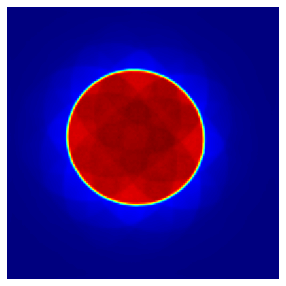

In [5]:
test = sstem_python(f_stack)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.original_pacbed, cmap="jet")
ax.axis("off")
plt.show()

[61.06111248943264, 59.944001768947096]


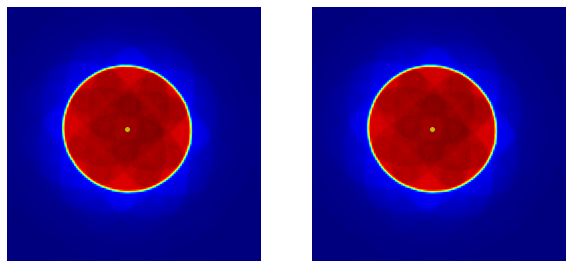

In [6]:
test.find_center(com=True, gaussian=False)
print(test.ct)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test.original_pacbed, cmap="jet")
ax[0].axis("off")
ax[0].scatter(test.com_ct[1], test.com_ct[0], s=15, c="y")
ax[1].imshow(test.original_pacbed, cmap="jet")
ax[1].axis("off")
ax[1].scatter(test.gauss_ct[1], test.gauss_ct[0], s=15, c="y")
plt.show()

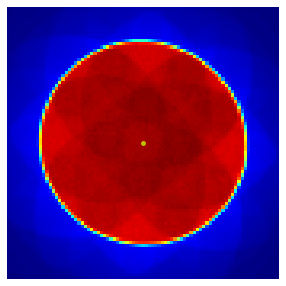

In [11]:
test.disk_extract(buffer_size=10)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.c_pacbed, cmap="jet")
ax.scatter(test.c_ct[1], test.c_ct[0], s=15, c="y")
ax.axis("off")
plt.show()